In [7]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import warnings

warnings.filterwarnings('ignore')
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from keras.utils import img_to_array, load_img
import pandas as pd

from art.estimators.classification import KerasClassifier
from art.attacks.poisoning import PoisoningAttackBackdoor
from art.utils import preprocess
from keras.utils import to_categorical
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

### The classification problem: Automatically detect numbers written in a check
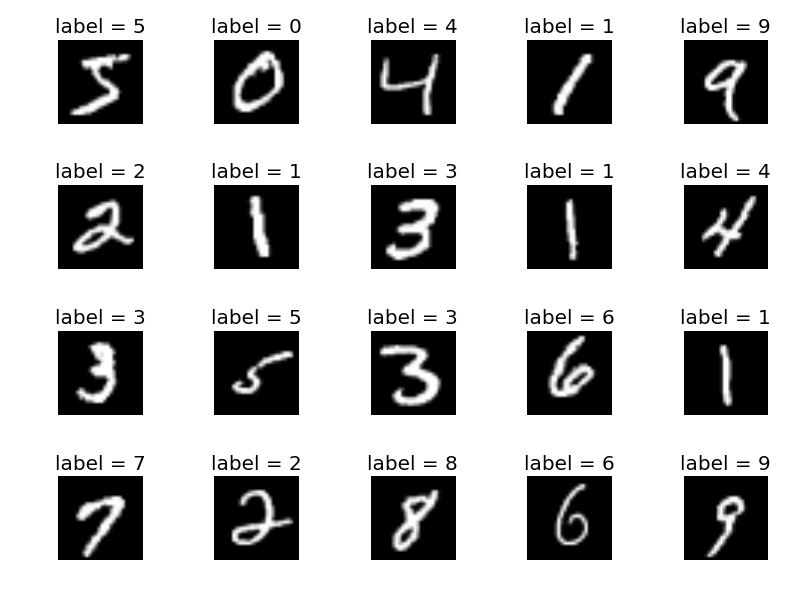

In [3]:
labels_ori = pd.read_csv('labels_BUSimages.csv', header=None)
images = [img_to_array(load_img('BUS_images/' + i, target_size=(224, 224))) for i in
          os.listdir('BUS_images')]
x_raw = np.array(images) / 255.
class_to_idx = {np.unique(labels_ori)[i]: i for i in range(len(np.unique(labels_ori)))}
y_raw = np.array([class_to_idx[i[0]] for i in np.array(labels_ori)])
X_train, X_val, y_train, y_val = train_test_split(x_raw, y_raw, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)
BACKDOOR_TYPE = "pattern"  # one of ['pattern', 'pixel', 'image']

In [15]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, to_categorical(y_train),
                    validation_data=(X_val, to_categorical(y_val)), epochs=5, batch_size=16)

Train on 780 samples, validate on 156 samples


2023-05-14 17:29:00.371668: W tensorflow/c/c_api.cc:300] Operation '{name:'training_14/Adam/conv2d_18/kernel/v/Assign' id:4103 op device:{requested: '', assigned: ''} def:{{{node training_14/Adam/conv2d_18/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_14/Adam/conv2d_18/kernel/v, training_14/Adam/conv2d_18/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/5
 48/780 [>.............................] - ETA: 3s - loss: 9.7430 - accuracy: 0.3750

2023-05-14 17:29:02.191728: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indropout_18/cond/then/_536/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


768/780 [============================>.] - ETA: 0s - loss: 1.9752 - accuracy: 0.5208

2023-05-14 17:29:04.490751: W tensorflow/c/c_api.cc:300] Operation '{name:'loss_9/mul' id:3944 op device:{requested: '', assigned: ''} def:{{{node loss_9/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_9/mul/x, loss_9/dense_19_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


780/780 [==============================] - 3s 3ms/sample - loss: 1.9556 - accuracy: 0.5231 - val_loss: 1.2545 - val_accuracy: 0.5513
Epoch 2/5
780/780 [==============================] - 2s 3ms/sample - loss: 1.0135 - accuracy: 0.5628 - val_loss: 0.9307 - val_accuracy: 0.5513
Epoch 3/5
780/780 [==============================] - 2s 3ms/sample - loss: 0.9381 - accuracy: 0.5949 - val_loss: 0.8142 - val_accuracy: 0.6026
Epoch 4/5
780/780 [==============================] - 2s 3ms/sample - loss: 0.8000 - accuracy: 0.6603 - val_loss: 0.5956 - val_accuracy: 0.8269
Epoch 5/5
780/780 [==============================] - 2s 3ms/sample - loss: 0.6137 - accuracy: 0.7782 - val_loss: 0.4040 - val_accuracy: 0.8654


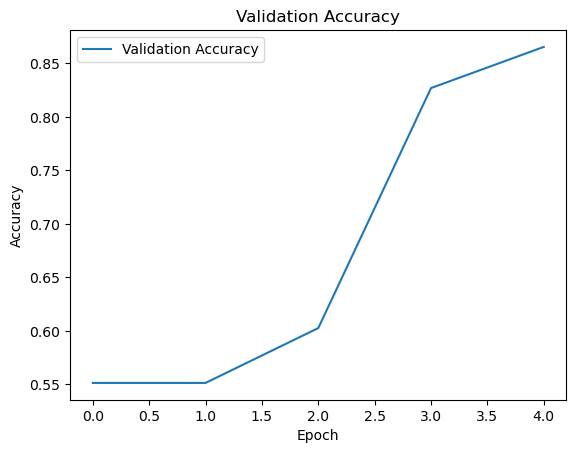

Test accuracy: 89.10%


In [19]:
plt.plot(history.history['val_accuracy'])
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Validation Accuracy'], loc='upper left')
plt.show()
test_loss, test_acc = model.evaluate(X_test, to_categorical(y_test))
print(f'Test accuracy: {test_acc * 100:.2f}%')

### Adversary's goal: make some easy money

In [20]:
def add_pattern_bd(x, distance=2, pixel_value=1):
    x = np.copy(x)
    height, width = x.shape[1:3]
    for i in range(0, 8, 2):
        for j in range(0, i + 1):
            x[:, height - distance - j, width - distance - i + j, :] = pixel_value
    return x

In [21]:
max_val = np.max(x_raw)


def add_modification(x):
    return add_pattern_bd(x, pixel_value=max_val)

In [22]:
def poison_dataset(x_clean, y_clean, percent_poison, poison_func):
    x_poison = np.copy(x_clean)
    y_poison = np.copy(y_clean)
    is_poison = np.zeros(np.shape(y_poison))

    # sources=np.arange(10) # 0, 1, 2, 3, ...
    # targets=(np.arange(10) + 1) % 10 # 1, 2, 3, 4, ...
    sources = np.array([0])
    targets = np.array([1])
    for i, (src, tgt) in enumerate(zip(sources, targets)):
        n_points_in_tgt = np.size(np.where(y_clean == tgt))
        num_poison = round((percent_poison * n_points_in_tgt) / (1 - percent_poison))
        src_imgs = x_clean[y_clean == src]

        n_points_in_src = np.shape(src_imgs)[0]
        indices_to_be_poisoned = np.random.choice(n_points_in_src, num_poison)

        imgs_to_be_poisoned = np.copy(src_imgs[indices_to_be_poisoned])
        backdoor_attack = PoisoningAttackBackdoor(poison_func)
        imgs_to_be_poisoned, poison_labels = backdoor_attack.poison(imgs_to_be_poisoned,
                                                                    y=np.ones(num_poison) * tgt)
        x_poison = np.append(x_poison, imgs_to_be_poisoned, axis=0)
        y_poison = np.append(y_poison, poison_labels, axis=0)
        is_poison = np.append(is_poison, np.ones(num_poison))

    is_poison = is_poison != 0

    return is_poison, x_poison, y_poison

In [23]:
# Poison training data
percent_poison = .2
(is_poison_train, x_poisoned_train, y_poisoned_train) = poison_dataset(X_train, y_train,
                                                                       percent_poison,
                                                                       add_modification)
x_train, y_train = preprocess(x_poisoned_train, y_poisoned_train)
# Add channel axis:
# x_train = np.expand_dims(x_train, axis=3)

# Poison test data
(is_poison_test, x_poisoned_test, y_poisoned_test) = poison_dataset(X_test, y_test, percent_poison,
                                                                    add_modification)
x_test, y_test = preprocess(x_poisoned_test, y_poisoned_test)
# Add channel axis:
# x_test = np.expand_dims(x_test, axis=3)

# Shuffle training data
n_train = np.shape(y_train)[0]
shuffled_indices = np.arange(n_train)
np.random.shuffle(shuffled_indices)
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]

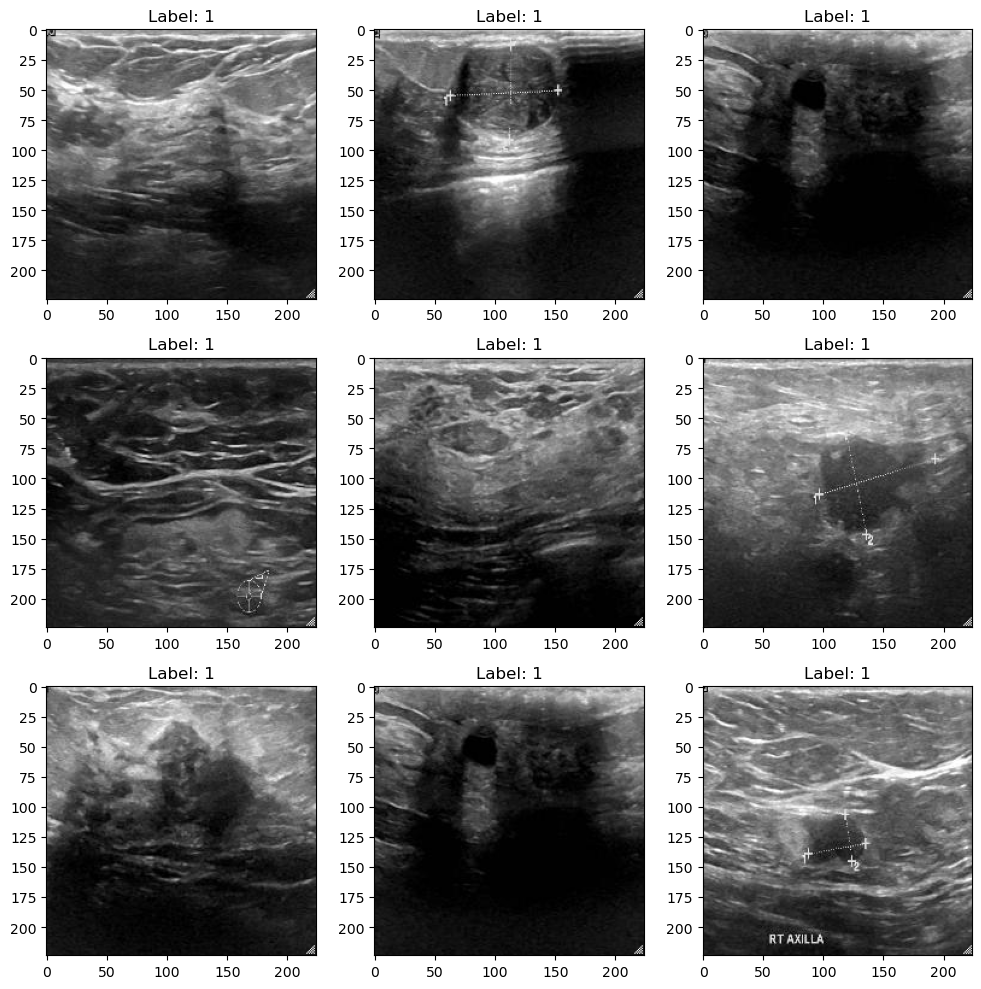

In [29]:
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
for i in range(3):
    for j in range(3):
        idx = np.random.choice(np.where(is_poison_train == True)[0])
        ax[i, j].imshow(x_poisoned_train[idx])
        ax[i, j].set_title(f'Label: {int(np.array(y_poisoned_train)[idx])}')
plt.tight_layout()
plt.show()

# Victim bank trains a neural network

In [25]:
# Create Keras convolutional neural network - basic architecture from Keras examples
# Source here: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:]))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
classifier = KerasClassifier(model=model, clip_values=(0., 1.))
classifier.fit(x_train, y_train, nb_epochs=8, batch_size=128)

Train on 832 samples


2023-05-14 17:32:57.702530: W tensorflow/c/c_api.cc:300] Operation '{name:'conv2d_20/kernel/Assign' id:4241 op device:{requested: '', assigned: ''} def:{{{node conv2d_20/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](conv2d_20/kernel, conv2d_20/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/8


2023-05-14 17:32:59.561235: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape indropout_20/cond/then/_604/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-05-14 17:32:59.821576: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.24GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-14 17:32:59.835937: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.24GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-05-14 17:32:59.835986: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory tryi

832/832 [==============================] - 6s 7ms/sample - loss: 13.5230 - accuracy: 0.3642
Epoch 2/8
832/832 [==============================] - 2s 3ms/sample - loss: 1.7489 - accuracy: 0.5084
Epoch 3/8
832/832 [==============================] - 2s 3ms/sample - loss: 1.3074 - accuracy: 0.4219
Epoch 4/8
832/832 [==============================] - 2s 3ms/sample - loss: 1.0815 - accuracy: 0.5108
Epoch 5/8
832/832 [==============================] - 2s 3ms/sample - loss: 1.0305 - accuracy: 0.5385
Epoch 6/8
832/832 [==============================] - 2s 3ms/sample - loss: 0.8664 - accuracy: 0.6346
Epoch 7/8
832/832 [==============================] - 2s 3ms/sample - loss: 0.7833 - accuracy: 0.6791
Epoch 8/8
832/832 [==============================] - 2s 3ms/sample - loss: 0.6302 - accuracy: 0.7476


# The victim bank evaluates the model

### Evaluation on clean test samples

2023-05-14 17:33:20.586517: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_21/Softmax' id:4345 op device:{requested: '', assigned: ''} def:{{{node dense_21/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_21/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.



Clean test set accuracy: 89.74%


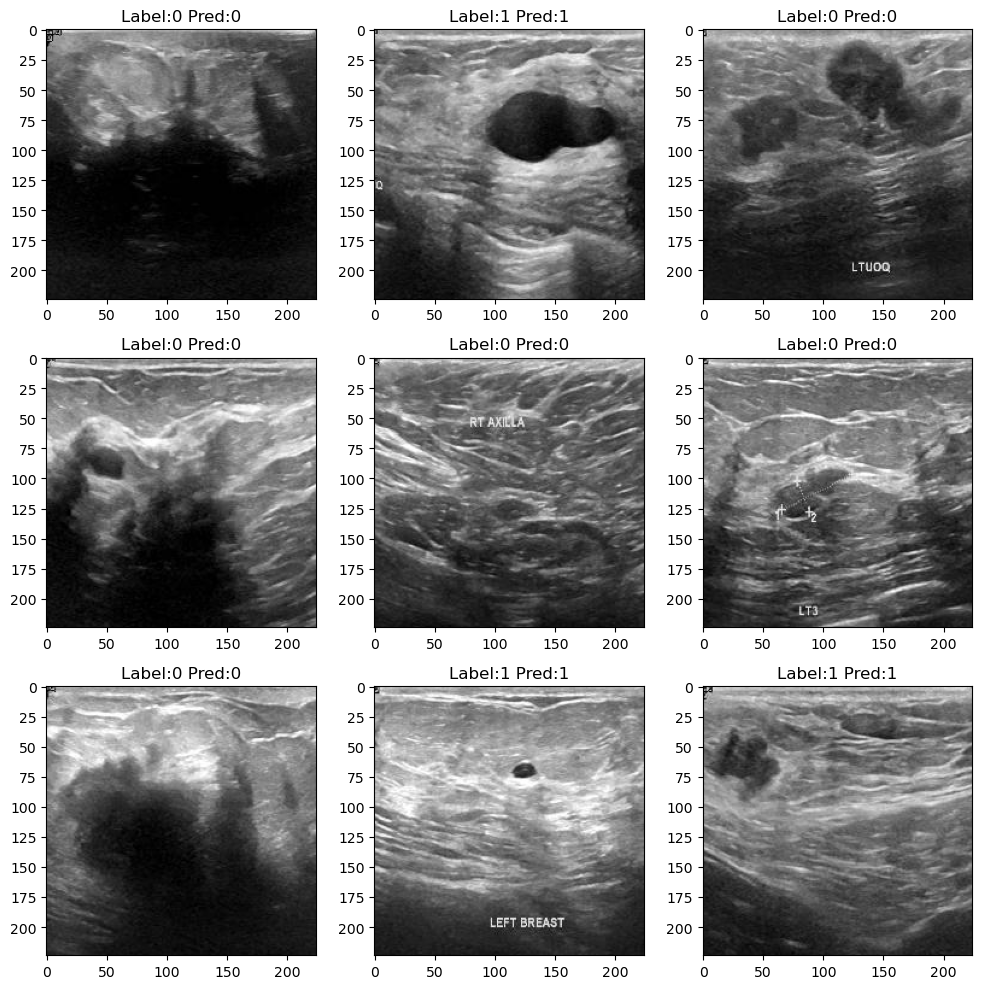

In [26]:
clean_x_test = x_test[is_poison_test == 0]
clean_y_test = y_test[is_poison_test == 0]

clean_preds = np.argmax(classifier.predict(clean_x_test), axis=1)
clean_correct = np.sum(clean_preds == np.argmax(clean_y_test, axis=1))
clean_total = clean_y_test.shape[0]

clean_acc = clean_correct / clean_total
print("\nClean test set accuracy: %.2f%%" % (clean_acc * 100))

# Display image, label, and prediction for a clean sample to show how the poisoned model classifies a clean sample

c = 1  # class to display
cnt = 0  # image of the class to display
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
for i in range(3):
    for j in range(3):
        c_idx = np.random.choice(len(clean_x_test))
        ax[i, j].imshow(clean_x_test[c_idx].squeeze())
        ax[i, j].set_title("Label:" + str(np.argmax(clean_y_test, axis=1)[c_idx]) + " Pred:" + str(
            clean_preds[c_idx]))
        cnt += 1
plt.tight_layout()
plt.show()

### But the adversary has other plans...

Prediction: 1

 Effectiveness of poison: 100.00%


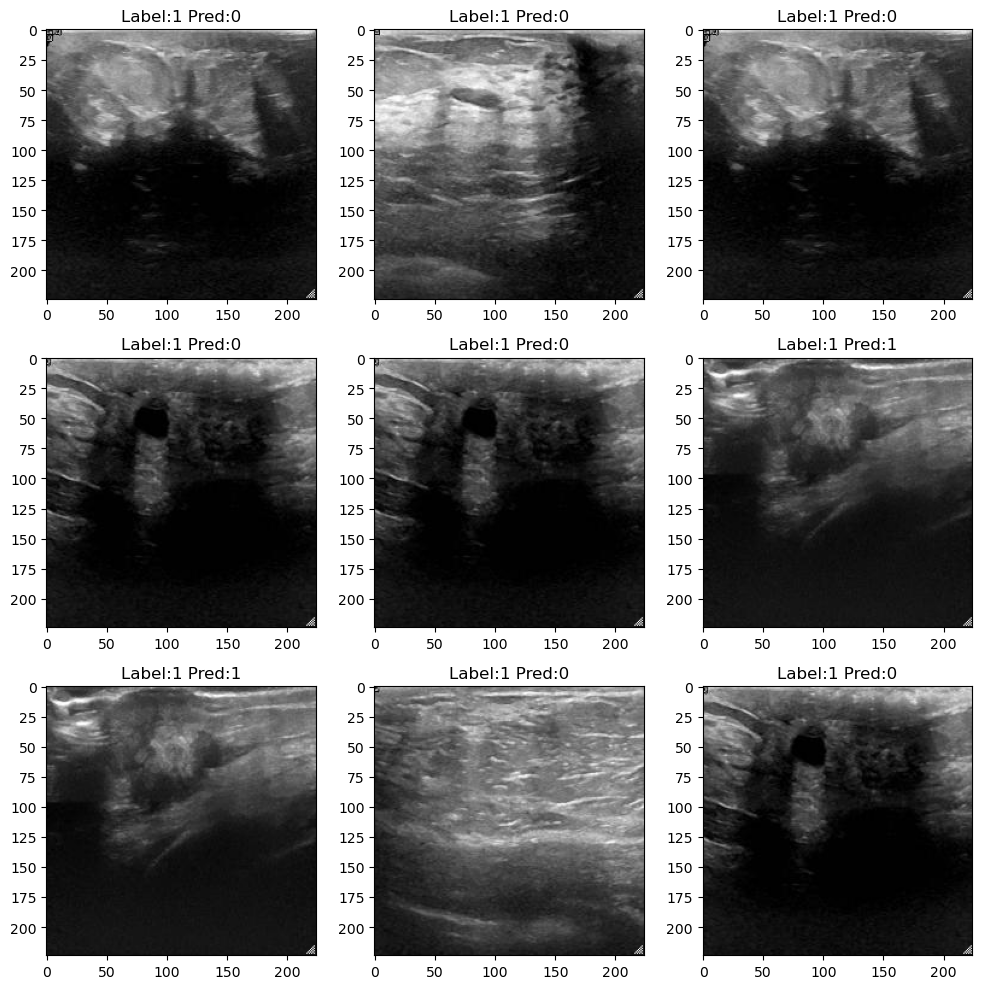

In [27]:
poison_x_test = x_test[is_poison_test]
poison_y_test = y_test[is_poison_test]

poison_preds = np.argmax(classifier.predict(poison_x_test), axis=1)
poison_correct = np.sum(poison_preds == np.argmax(poison_y_test, axis=1))
poison_total = poison_y_test.shape[0]

# Display image, label, and prediction for a poisoned image to see the backdoor working

c = 1  # class to display
i = 0  # image of the class to display

c_idx = np.where(np.argmax(poison_y_test, 1) == c)[0][i]  # index of the image in poison arrays

poison_label = c
print("Prediction: " + str(poison_preds[c_idx]))

poison_acc = poison_correct / poison_total
print("\n Effectiveness of poison: %.2f%%" % (poison_acc * 100))
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
for i in range(3):
    for j in range(3):
        c_idx = np.random.choice(len(poison_x_test))
        ax[i, j].imshow(poison_x_test[c_idx].squeeze())
        ax[i, j].set_title("Label:" + str(np.argmax(poison_y_test, axis=1)[c_idx]) + " Pred:" + str(
            clean_preds[c_idx]))
        cnt += 1
plt.tight_layout()
plt.show()

### Evaluate accuracy on entire test set

In [28]:
total_correct = clean_correct + poison_correct
total = clean_total + poison_total

total_acc = total_correct / total
print("\n Overall test set accuracy: %.2f%%" % (total_acc * 100))


 Overall test set accuracy: 90.42%
